# Set kernel to: `py-pythonEnv`
If this kernel is not available, see the Kernel Installation Instructions section located in at the bottom of this Notebook.

# C3  Data Science on the C3 AI Suite
## C3DS - Machine Leaning Model Development \& Deployment

#### For questions, comments, or concerns, please email the C3.ai Academy Team \< training@c3.ai \>, discuss with your Trainer, or leave your thoughts in the Google Forms at the end of this module.

## Table of Contents 

__[C3DS ML Model Development & Deployment](#part1)__

* [Section 1 - Introduction](#1)
    * [A. Packages](#1a)
    * [B. C3 Dataset Tutorial](#1b)


* [Section 2 - Data Exploration \& Data Preparation](#2)
    * [A. Checking Data](#2a)
    * [B. Creating Failure Labels](#2b)
    * [C. Creating Training \& Test Sets](#2c)
    

* [Section 3 - Method 1: Train Locally](#3)
    * [A. Convert to Pandas DataFrame](#3a)
    * [B. Packages](#3b)
    * [C. Train Locally](#3c)    
    * [D. Evaluate Results](#3d)        
    * [E. Upsert Model](#3e) 
    
    
* [Section 4 - Method 2: Train on the platform](#4)
    * [A. Data Preparation](#4a)
    * [B. Define C3 Machine Learning Pipelines](#4b)
    * [C. Evaluate Training Results](#4c)
    * [D. Predict Probabilities](#4d)
    * [E. Upsert Model](#4e)
    * [F. Upsert Risk Scores](#4f)
    

* [Section 5 - Improve Results on the Platform](#5)
    * [A. Change Features](#5a)
    * [B. Change What is in the Pipeline - Build Scaler + Random Forest](#5b)
    * [C. Change What is in the Pipeline - Build Your Own Pipeline (Optional)](#5c)
    * [D. Upsert Model](#5e) 
    
    
* [Section 6 - Define a Custom Pipe implemented in Python (Optional)](#6)

[Appendix - Kernel Installation Instructions](#apdx)

# C3DS ML Model Development \& Deployment <a class="anchor" id="part1">

## Exercise Goal
This assignment will first take you through building a machine learning model locally and then give you a chance to build a machine learning model on C3 AI Suite.
    
<a id='1'></a>
## Section 1 - Introduction



<a id='1'></a>
<b> Training Machine Learning Models with C3 </b>

Welcome to your modeling assignment! You will train a machine learning model to predict lightbulb failure both locally and on C3 AI Suite. This assignment will step you through data processing, pipeline building, model training, using the model to predict, model tuning, and model upsertion.

- Building machine learning models with C3 including the following:
    1. Create failure labels
    2. Fetch data and prepare data to train
    3. Define pipelines
    4. Use your defined pipelines to train
    5. Evaluate results
    6. Hyperparameter tuning

<a id='1a'></a>
### A. Packages

First, let's run the cell below to import all the packages.

In [1]:
import pandas as pd # For handling DataFrames
import numpy as np 
import collections
from sklearn import metrics
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

%matplotlib inline

<a id='1b'></a>
### B. C3 Dataset Tutorial

The C3 Dataset type is the type we use to create a dataframe or a matrix of numerical values in C3. Using the C3 `Dataset` type is essential for model development in C3, so this section will focus on how to **create, manipulate, and use** C3 Dataset objects.

There are three main methods on the Dataset type we call to create Dataset objects:
1. `fromDFE` - converts a CompoudDFE into a Dataset;
2. `fromEvalMetricResult` - converts an EvalMetricResult into a Dataset;
3. `fromPython` - converts a numpy array or pandas DataFrame into a Dataset.

In this tutorial, we will demonstrate the third method to create a Dataset object, but please use `c3ShowType(Dataset)` in the JS console to reference documentation on the other two methods.

First we'll create a pandas `DataFrame` that we want to convert to a C3 `Dataset` object.

In [2]:
df = pd.DataFrame([[1.0, 100.0, -2.0], [3.0, 50.5, 10.1], [-2.0, -23.0, 3.2]], columns=["a", "b", "c"])
df

a      b     c
0  1.0  100.0  -2.0
1  3.0   50.5  10.1
2 -2.0  -23.0   3.2

Now, we'll convert this pandas `DataFrame` into a C3 `Dataset` using the `fromPython` function, as follows:

In [3]:
ds = c3.Dataset.fromPython(df)
ds

c3.Dataset(
 shape=c3.Arry<int>([3, 3]),
 indices=c3.Mapp<int, [string]>({0: c3.Arry<string>(['0', '1', '2']),
           1: c3.Arry<string>(['a', 'b', 'c'])}),
 m_data=c3.Arry<double>([1.0, 100.0, -2.0, 3.0, 50.5, 10.1, -2.0, -23.0, 3.2]))

Notice that the shape, data, column names, and indices are all extracted from the original pandas `DataFrame`.

However, in a Jupyter notebook, we often want to view a `Dataset` object as a pandas `DataFrame` in order to print it nicely. For this, we use the Dataset member function `toPandas`, which you can see preserved all the information in the original dataframe:

In [4]:
c3.Dataset.toPandas(dataset=ds)

a      b     c
0  1.0  100.0  -2.0
1  3.0   50.5  10.1
2 -2.0  -23.0   3.2

Once we have a C3 `Dataset`, many common operations are also available to manipulate the `Dataset` object, such as `slice` and `transpose`, and `shuffle`:

In [5]:
transposed_ds = ds.transpose()
c3.Dataset.toPandas(transposed_ds)

0     1     2
a    1.0   3.0  -2.0
b  100.0  50.5 -23.0
c   -2.0  10.1   3.2

In [6]:
middle_column_ds = ds.slice(indices=[1], axis=1)
c3.Dataset.toPandas(middle_column_ds)

b
0  100.0
1   50.5
2  -23.0

In [7]:
shuffled_ds = ds.shuffle()
c3.Dataset.toPandas(shuffled_ds)

a      b     c
2 -2.0  -23.0   3.2
0  1.0  100.0  -2.0
1  3.0   50.5  10.1

Now that you're familiar with the C3 Dataset object, let's begin developing some models!

<a id='2'></a>
## Section 2 - Data Exploration \& Data Preparation

<a id='2a'></a>
### A. Checking Data

Before training the model, we want to fetch the data and visualize what we are looking at.

First, let's look at the SmartBulbs: the targets of the machine learning model that we are going to build.
There are two ways to specify which data to fetch from the platform: (1) Define a FetchSpec
2. Pass in a dictionary

**Note**: 
1. There is no auto-complete in order to avoid confusion;
2. `toJson()` will give you a pretty display of the results;
3. You need to specify the parameters names when calling functions.

Here are the two examples. Throughout this notebook, feel free to use either method for your fetch calls.

In [2]:
# Fetch using FetchSpec
fetch_spec = c3.FetchSpec(filter = "contains(id, 'SMB')", limit = 1)
c3.SmartBulb.fetch(spec=fetch_spec).toJson()

{'type': 'FetchResult<SmartBulb>',
 'objs': [{'type': 'SmartBulb',
   'typeIdent': 'SMRT_BLB',
   'id': 'SMBLB1',
   'meta': {'type': 'Meta',
    'tenantTagId': 21,
    'tenant': 'c3training',
    'tag': 'dev16',
    'created': '2020-06-15T22:01:38+00:00',
    'createdBy': 'provisioner',
    'updated': '2020-06-15T22:01:38+00:00',
    'updatedBy': 'provisioner',
    'timestamp': '2020-07-08T14:49:25+00:00',
    'fetchInclude': '[]',
    'fetchType': 'SmartBulb'},
   'version': 1114113,
   'bulbType': 'LED',
   'wattage': 9.5,
   'manufacturer': {'type': 'Manufacturer', 'id': 'Bell'},
   'startDate': '2011-01-01T04:00:00-08:00',
   'currentPrediction': {'type': 'SmartBulbPrediction', 'id': 'SMBLB1#BO4BM'},
   'latitude': 37.48596719,
   'longitude': -122.2428196,
   'lumensUOM': {'type': 'Unit', 'id': 'lumen'},
   'powerUOM': {'type': 'Unit', 'id': 'watt'},
   'temperatureUOM': {'type': 'Unit', 'id': 'degrees_fahrenheit'},
   'voltageUOM': {'type': 'Unit', 'id': 'volt'},
   'currentFixt

In [ ]:
# Fetch using a dictionary to define the spec 
c3.SmartBulb.fetch(spec={'filter': "contains(id, 'SMB')", 'limit': 1}).toJson()

It is possible to cast the fetched object into a pandas dataframe for better visualization.

In [3]:
tdf = pd.DataFrame(c3.SmartBulb.fetch(spec={'filter': "contains(id, 'SMB')"}).objs.toJson())
tdf.head(3)

type typeIdent        id  \
0  SmartBulb  SMRT_BLB    SMBLB1   
1  SmartBulb  SMRT_BLB   SMBLB10   
2  SmartBulb  SMRT_BLB  SMBLB100   

                                                meta  version bulbType  \
0  {'type': 'Meta', 'tenantTagId': 21, 'tenant': ...   262145      LED   
1  {'type': 'Meta', 'tenantTagId': 21, 'tenant': ...   262145      LED   
2  {'type': 'Meta', 'tenantTagId': 21, 'tenant': ...   262145    INCAN   

   wattage                            manufacturer                  startDate  \
0      9.5  {'type': 'Manufacturer', 'id': 'Bell'}  2011-01-01T04:00:00-08:00   
1      9.5    {'type': 'Manufacturer', 'id': 'GE'}  2011-01-01T04:00:00-08:00   
2     60.0    {'type': 'Manufacturer', 'id': 'GE'}  2011-01-01T04:00:00-08:00   

                                   currentPrediction   latitude   longitude  \
0  {'type': 'SmartBulbPrediction', 'id': 'SMBLB1#...  37.485967 -122.242820   
1  {'type': 'SmartBulbPrediction', 'id': 'SMBLB10...  37.484950 -122.233511   
2  {'type': 'SmartBulbPrediction', 'id': 'SMBLB10...  37.483786 -122.244751   

                         lumensUOM                        powerUOM  \
0  {'type': 'Unit', 'id': 'lumen'}  {'type': 'Unit', 'id': 'watt'}   
1  {'type': 'Unit', 'id': 'lumen'}  {'type': 'Unit', 'id': 'watt'}   
2  {'type': 'Unit', 'id': 'lumen'}  {'type': 'Unit', 'id': 'watt'}   

                                 temperatureUOM  \
0  {'type': 'Unit', 'id': 'degrees_fahrenheit'}   
1  {'type': 'Unit', 'id': 'degrees_fahrenheit'}   
2  {'type': 'Unit', 'id': 'degrees_fahrenheit'}   

                       voltageUOM                        currentFixture  
0  {'type': 'Unit', 'id': 'volt'}    {'type': 'Fixture', 'id': 'fixt1'}  
1  {'type': 'Unit', 'id': 'volt'}   {'type': 'Fixture', 'id': 'fixt10'}  
2  {'type': 'Unit', 'id': 'volt'}  {'type': 'Fixture', 'id': 'fixt100'}

In [10]:
type(tdf.currentFixture[0]['id'])

str

In [13]:
#tdf.head(3)

Now, can you fetch the Smartbulbs that their manufacturer names' start with 'B' and are LED bulbs?

In [4]:
### START CODE HERE ### (≈ 2 lines of code)
fRes = c3.SmartBulb.fetch(spec={'filter': "startsWith(manufacturer.id, 'B')"})
pd.DataFrame(fRes.objs.toJson()).head(3)
### END CODE HERE ###

type typeIdent       id  \
0  SmartBulb  SMRT_BLB   SMBLB1   
1  SmartBulb  SMRT_BLB  SMBLB12   
2  SmartBulb  SMRT_BLB  SMBLB14   

                                                meta  version bulbType  \
0  {'type': 'Meta', 'tenantTagId': 21, 'tenant': ...   262145      LED   
1  {'type': 'Meta', 'tenantTagId': 21, 'tenant': ...   262145      LED   
2  {'type': 'Meta', 'tenantTagId': 21, 'tenant': ...   262145      LED   

   wattage                            manufacturer                  startDate  \
0      9.5  {'type': 'Manufacturer', 'id': 'Bell'}  2011-01-01T04:00:00-08:00   
1      9.5  {'type': 'Manufacturer', 'id': 'Bell'}  2011-01-01T04:00:00-08:00   
2      9.5  {'type': 'Manufacturer', 'id': 'Bell'}  2011-01-01T04:00:00-08:00   

                                   currentPrediction   latitude   longitude  \
0  {'type': 'SmartBulbPrediction', 'id': 'SMBLB1#...  37.485967 -122.242820   
1  {'type': 'SmartBulbPrediction', 'id': 'SMBLB12...  37.492409 -122.236505   
2  {'type': 'SmartBulbPrediction', 'id': 'SMBLB14...  37.491864 -122.232971   

                         lumensUOM                        powerUOM  \
0  {'type': 'Unit', 'id': 'lumen'}  {'type': 'Unit', 'id': 'watt'}   
1  {'type': 'Unit', 'id': 'lumen'}  {'type': 'Unit', 'id': 'watt'}   
2  {'type': 'Unit', 'id': 'lumen'}  {'type': 'Unit', 'id': 'watt'}   

                                 temperatureUOM  \
0  {'type': 'Unit', 'id': 'degrees_fahrenheit'}   
1  {'type': 'Unit', 'id': 'degrees_fahrenheit'}   
2  {'type': 'Unit', 'id': 'degrees_fahrenheit'}   

                       voltageUOM                       currentFixture  
0  {'type': 'Unit', 'id': 'volt'}   {'type': 'Fixture', 'id': 'fixt1'}  
1  {'type': 'Unit', 'id': 'volt'}  {'type': 'Fixture', 'id': 'fixt12'}  
2  {'type': 'Unit', 'id': 'volt'}  {'type': 'Fixture', 'id': 'fixt14'}

Since the output is too big, here is showing part of the results. But you can check if the smartbulbs have their manufacturer names' start with '**B**' and are **LED** bulbs.

![title](http://learnc3.ai/wp-content/uploads/2020/01/fetchAnswer2.png)

Let's also look at what metrics we have created for `SmartBulb` in the previous lessons. This will be helpful in the last part of the assignment where you will choose your own set of features to train from.

In [5]:
pd.DataFrame(c3.SmartBulb.listMetrics().toJson())

type                                name  \
0     SimpleMetric                       AverageLumens   
1     SimpleMetric                        AveragePower   
2     SimpleMetric                  AverageTemperature   
3     SimpleMetric                      AverageVoltage   
4     SimpleMetric              ConnectivityEventCount   
5   CompoundMetric               CumulativeSwitchCount   
6   CompoundMetric                           DayOfWeek   
7   CompoundMetric                           DayOfYear   
8   CompoundMetric                          DaysInYear   
9   CompoundMetric                   DurationOnInHours   
10    SimpleMetric                  FeatureCountSeries   
11  CompoundMetric                       HasEverFailed   
12  CompoundMetric                             Holiday   
13  CompoundMetric                           HourOfDay   
14  CompoundMetric                          HourOfWeek   
15  CompoundMetric                         IsDefective   
16    SimpleMetric                 LightningEventCount   
17  CompoundMetric                         MonthOfYear   
18  CompoundMetric                       NonWorkingDay   
19  CompoundMetric                        NumberOfDays   
20  CompoundMetric                       NumberOfHours   
21    SimpleMetric                    OutageEventCount   
22  CompoundMetric                       OutageWhileOn   
23  CompoundMetric                    PowerConsumption   
24  CompoundMetric                   ProminentFeatures   
25    SimpleMetric                           RiskScore   
26  CompoundMetric  StandardDeviationWattsPreviousWeek   
27    SimpleMetric                              Status   
28  CompoundMetric                         SwitchCount   
29  CompoundMetric             SwitchCountPreviousWeek   
30  CompoundMetric                   WillFailNextMonth   
31    SimpleMetric                                 m13   

                                           expression  \
0                    avg(avg(normalized.data.lumens))   
1                     avg(avg(normalized.data.power))   
2               avg(avg(normalized.data.temperature))   
3                   avg(avg(normalized.data.voltage))   
4                                                 NaN   
5                         rolling('SUM', SwitchCount)   
6                 timeComponent('DAYOFWEEK', start())   
7                 timeComponent('DAYOFYEAR', start())   
8   timeComponent('YEAR', start()) % 4 != 0 || (ti...   
9            rolling('SUM',sum(eval('HOUR', Status)))   
10                                                NaN   
11                 rolling('SUM',IsDefective) ? 1 : 0   
12                             holiday(identity(1.0))   
13                     timeComponent('HOUR', start())   
14                 ((DayOfWeek - 1) * 24) + HourOfDay   
15  sum(eval('HOUR', AverageLumens == 0 && Status ...   
16                                                NaN   
17                    timeComponent('MONTH', start())   
18  Holiday || timeComponent('DAYOFWEEK', start())...   
19               (end() - start()) / period(1, 'DAY')   
20              (end() - start()) / period(1, 'HOUR')   
21                                                NaN   
22  sum(eval('HOUR', OutageEventCount == 1 && Stat...   
23  rolling('SUM',sum(eval('HOUR', AveragePower)))...   
24         nMostProminentFeatures(AllNLFeaturesTS, N)   
25         identity(currentPrediction.prediction/365)   
26  eval('AVG', 'DAY', window('STDDEV', AveragePow...   
27                   avg(avg(normalized.data.status))   
28        sum(eval('HOUR', abs(rollingDiff(Status))))   
29                  window('SUM', SwitchCount, -7, 7)   
30              window('MAX', IsDefective, 0, 30) > 0   
31                                                NaN   

                                                 meta  \
0   {'type': 'Meta', 'tenantTagId': 21, 'tenant': ...   
1   {'type': 'Meta', 'tenantTagId': 21, 'tenant': ...   
2   {'type': 'Meta', 'tenantTagId': 21, 'tenan

This metric will be `1` if the bulb has been marked as defective in the upcoming **45 days**. 

In [3]:
### START CODE HERE ### (≈ 3 lines of code)
failure_metric = c3.CompoundMetric(
    id = "FailureWindow",
    name = "FailureWindow_SmartBulb",
    expression = "window('MAX', IsDefective, 0, 30) > 0"
)
### END CODE HERE ###
failure_metric

c3.CompoundMetric(
 name='FailureWindow_SmartBulb',
 expression="window('MAX', IsDefective, 0, 30) > 0",
 id='FailureWindow')

Now, let's visualize what we just created. We can get data from C3 AI Suite using the compound metrics expression that we just defined. The `overrideMetrics` parameter specifies that metrics we defined on the fly that we want to use instead of already provisioned metrics on the platform.

In [4]:
start = datetime(2011,1,1)
end = datetime(2017,1,1)
interval = 'DAY'
expressions = ["FailureWindow"]
spec = c3.EvalMetricsSpec(expressions = expressions,
                          filter = "startsWith(id, 'SMBLB')",
                          interval = interval,
                          start = start,
                          end = end,
                          limit = 100)

res = c3.SmartBulb.evalMetricsWithMetadata(spec=spec, overrideMetrics = [failure_metric])

This tells you the proportion of positive labels versus negative labels.

In [5]:
# Create a c3 Dataset object from the EvalMetricsResult object.
ds = c3.Dataset.fromEvalMetricsResult(result = res)
# Create a Pandas dataframe from the c3 Dataset object
df = c3.Dataset.toPandas(dataset = ds)

To plot the timeseries for a single smartbulb, it is useful to split the index into "source" and "timestamp":

In [6]:
df['source'] = df.index.str.split('_').str[0]
df['timestamp'] = pd.to_datetime(df.index.str.split('_').str[1],format="%Y-%m-%dT%H:%M:%S.%f")

In [20]:
df.timestamp[-1]

Timestamp('2016-12-31 00:00:00')

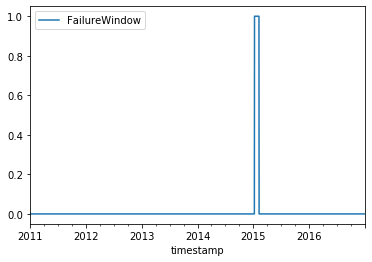

In [21]:
df[df['source']=='SMBLB1'].plot(x='timestamp',y='FailureWindow')

**Expected Output**:

![title](http://learnc3.ai/wp-content/uploads/2020/01/failureMetric2.png)

The dataset looks pretty imbalanced with about only 2.5% of the set consisting of positive labels. We have also visualized part of the failure label. Note that the periods where the FailureWindow value is equal to 1 represent the 45 days right before the failure happens. 

<a id='2c'></a>
### C. Create Training \& Test Sets

For now, we will select four metrics to evaluate.
- 2 metrics will be features used for training the model.
- The metric `FailureWindow` will be the label (the one that you have just created).
- A metric to mask out unnecessary data. In this case we want to exclude data after the bulb has failed.

In [60]:
features = [
    "DurationOnInHours",
    "SwitchCountPreviousWeek"
]

mask = 'HasEverFailed'
label = 'FailureWindow'

columns = features + [mask, label]
print(columns)

['DurationOnInHours', 'SwitchCountPreviousWeek', 'HasEverFailed', 'FailureWindow']


In order to split training and test sets, we will split by the smartbulb id. We will **"hold-out"** the smartbulbs with `ids` beginning with **"SMBLB1*"** or **"SMBLB2*"** (≈20% population) for testing, and train on the remaining (≈80% population) lightbulbs.
> Note: Test yourself by running a single JS console command to see this.

The interval of data will be **daily**. Can you create a training and test set? In the cell below, create the train dataset. Then, in the following cell, create the test set.

In [61]:
### START CODE HERE ### (≈ 9 lines of code)
start = datetime(2011,1,1)
end = datetime(2017,1,1)
interval = 'DAY'

spec = c3.EvalMetricsSpec(expressions = columns,
                          filter = "!(startsWith(id, 'SMBLB1') || startsWith(id, 'SMBLB2'))",
                          interval = interval,
                          start = start,
                          end = end)

res_train = c3.SmartBulb.evalMetricsWithMetadata(spec=spec, overrideMetrics=[failure_metric])
### END CODE HERE ###
ds_train = c3.Dataset.fromEvalMetricsResult(result = res_train)

df_train = c3.Dataset.toPandas(dataset = ds_train)
df_train.head(10)

DurationOnInHours  FailureWindow  HasEverFailed  \
SMBLB3_2011-01-01T00:00:00                2.0            0.0            0.0   
SMBLB3_2011-01-02T00:00:00               10.0            0.0            0.0   
SMBLB3_2011-01-03T00:00:00               17.0            0.0            0.0   
SMBLB3_2011-01-04T00:00:00               28.0            0.0            0.0   
SMBLB3_2011-01-05T00:00:00               37.0            0.0            0.0   
SMBLB3_2011-01-06T00:00:00               47.0            0.0            0.0   
SMBLB3_2011-01-07T00:00:00               50.0            0.0            0.0   
SMBLB3_2011-01-08T00:00:00               55.0            0.0            0.0   
SMBLB3_2011-01-09T00:00:00               66.0            0.0            0.0   
SMBLB3_2011-01-10T00:00:00               73.0            0.0            0.0   

                            SwitchCountPreviousWeek  
SMBLB3_2011-01-01T00:00:00                      0.0  
SMBLB3_2011-01-02T00:00:00                      2.0  
SMBLB3_2011-01-03T00:00:00                     10.0  
SMBLB3_2011-01-04T00:00:00                     14.0  
SMBLB3_2011-01-05T00:00:00                     20.0  
SMBLB3_2011-01-06T00:00:00                     28.0  
SMBLB3_2011-01-07T00:00:00                     34.0  
SMBLB3_2011-01-08T00:00:00                     38.0  
SMBLB3_2011-01-09T00:00:00                     38.0  
SMBLB3_2011-01-10T00:00:00                     36.0

... and now the test set:

In [62]:
### START CODE HERE ### (≈ 9 lines of code)
start = datetime(2011,1,1)
end = datetime(2017,1,1)
interval = 'DAY'

spec = c3.EvalMetricsSpec(expressions = columns,
                          filter = "(startsWith(id, 'SMBLB1') || startsWith(id, 'SMBLB2'))",
                          interval = interval,
                          start = start,
                          end = end)

res_test = c3.SmartBulb.evalMetricsWithMetadata(spec=spec, overrideMetrics=[failure_metric])
### END CODE HERE ### 
ds_test = c3.Dataset.fromEvalMetricsResult(result = res_test)

df_test = c3.Dataset.toPandas(dataset = ds_test)
df_test.head(10)

DurationOnInHours  FailureWindow  HasEverFailed  \
SMBLB1_2011-01-01T00:00:00                3.0            0.0            0.0   
SMBLB1_2011-01-02T00:00:00               13.0            0.0            0.0   
SMBLB1_2011-01-03T00:00:00               21.0            0.0            0.0   
SMBLB1_2011-01-04T00:00:00               33.0            0.0            0.0   
SMBLB1_2011-01-05T00:00:00               43.0            0.0            0.0   
SMBLB1_2011-01-06T00:00:00               49.0            0.0            0.0   
SMBLB1_2011-01-07T00:00:00               52.0            0.0            0.0   
SMBLB1_2011-01-08T00:00:00               56.0            0.0            0.0   
SMBLB1_2011-01-09T00:00:00               64.0            0.0            0.0   
SMBLB1_2011-01-10T00:00:00               74.0            0.0            0.0   

                            SwitchCountPreviousWeek  
SMBLB1_2011-01-01T00:00:00                      0.0  
SMBLB1_2011-01-02T00:00:00                      4.0  
SMBLB1_2011-01-03T00:00:00                      8.0  
SMBLB1_2011-01-04T00:00:00                     16.0  
SMBLB1_2011-01-05T00:00:00                     20.0  
SMBLB1_2011-01-06T00:00:00                     24.0  
SMBLB1_2011-01-07T00:00:00                     30.0  
SMBLB1_2011-01-08T00:00:00                     34.0  
SMBLB1_2011-01-09T00:00:00                     34.0  
SMBLB1_2011-01-10T00:00:00                     38.0

In [29]:
print("training set shape: ", df_train.shape)
print("testing set shape: ", df_test.shape)

training set shape:  (168784, 4)
testing set shape:  (50416, 4)


**Expected Output**:

This is partial data. You should double check the fields as well as timestamps included in your dataset.

The training set should have the shape of **168784 rows × 4 columns**:

![title](http://learnc3.ai/wp-content/uploads/2020/01/traindfAnswer_new3.png)

And the test set should have shape of **50416 rows × 4 columns**:

![title](http://learnc3.ai/wp-content/uploads/2020/01/testdfAnswer_new3.png)

The reason why we have overrideMetrics is because you have created the failure_metric on the fly. If everything has already been provisioned to the platform, we do not need overrideMetrics anymore.

<a id='3'></a>
## Section 3 - Method 1: Train Locally

Now you are ready to train (locally)! 

Training locally is **not recommended**, for a number of reason, but most importantly, the models that have been trained locally cannot be retrained after you upserted them onto the platform. 

However, training locally will be very familiar to you! You can use whatever method you want to train a SkLearn pipeline. After you have trained a SkLearn pipeline, you can upsert the model onto the platform. Also, you may have some pre-trained model that you want to upsert to the C3 AI Suite. 

Even though you can do it now, it is recommended that you will follow Method 2's apporach and define the pipeline in the C3 fashion (i.e., training on the platform). That way, you can train timely and continously with Cron jobs and with the full support of C3.

<a id='3a'></a>
### A. Convert to Pandas DataFrame

Even though this may not be the only way, converting the object that you have created to a pandas `DataFrame` will make training in SkLearn pipeline very easy. You can use helper function to convert the C3 objects to pandas `DataFrame`.

Below, let's create a C3 `Dataset` object and convert that to a training `DataFrame`; we'll directly follow with a test `Dataset` and `DataFrame`:

In [13]:
ds_train = c3.Dataset.fromEvalMetricsResult(result = res_train)
df_train = c3.Dataset.toPandas(dataset = ds_train)

In [14]:
ds_test = c3.Dataset.fromEvalMetricsResult(result = res_test)
df_test = c3.Dataset.toPandas(dataset = ds_test)

<a id='3b'></a>
### B. Packages

These are the packages to import just for illustration purposes. The actual pakcages to import in order to train depends on individual use cases. Here, since we will be building a Sklearn Pipeline with two steps: 1. **Standard Scaler** \& 2. **Logistic Regression**, these are the packages to import:

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

Since we are building a model to predict light bulb failure, **we will exclude the light bulbs that have never failed**. Here, you will create training and test set with **two features** (`SwitchCountPreviousWeek`, `DurationOnInHours`) and **one label** (`FailureWindow`). 


> Note: Those who may be unfamiliar with the `x` \& `y` notation of `x_test` \& `y_test`, `x*` means **features** and `y*` means **labels**.

<a id='3c'></a>
### C. Train Locally
Below, we'll create the train test split:

In [33]:
df_train['source'] = df_train.index.str.split('_').str[0]
df_train_gr = df_train.groupby('source')
df_train_gr['HasEverFailed'].sum()

df_test['source'] = df_test.index.str.split('_').str[0]
df_test_gr = df_test.groupby('source')
df_test_gr['HasEverFailed'].sum()

source
SMBLB1      695.0
SMBLB10     774.0
SMBLB100    794.0
SMBLB11     757.0
SMBLB12     783.0
SMBLB13     800.0
SMBLB14     818.0
SMBLB15     747.0
SMBLB16     827.0
SMBLB17     761.0
SMBLB18     800.0
SMBLB19     786.0
SMBLB2      810.0
SMBLB20     801.0
SMBLB21     689.0
SMBLB22     832.0
SMBLB23     846.0
SMBLB24     800.0
SMBLB25     836.0
SMBLB26     807.0
SMBLB27     788.0
SMBLB28     803.0
SMBLB29     768.0
Name: HasEverFailed, dtype: float64

In [16]:
### START CODE HERE ### (≈ 4 lines of code)
x_train = df_train[df_train.HasEverFailed == 0][features]
y_train = df_train[df_train.HasEverFailed == 0][[label]]
x_test = df_test[df_test.HasEverFailed == 0][features]
y_test = df_test[df_test.HasEverFailed == 0][[label]]
### END CODE HERE ### 
print("x_train shape is " + str(x_train.shape))
print("y_train shape is " + str(y_train.shape))
print("x_test shape is " + str(x_test.shape))
print("y_test shape is " + str(y_test.shape))

x_train shape is (108340, 2)
y_train shape is (108340, 1)
x_test shape is (32294, 2)
y_test shape is (32294, 1)


In [48]:
y_test.head()

FailureWindow
SMBLB1_2011-01-01T00:00:00            0.0
SMBLB1_2011-01-02T00:00:00            0.0
SMBLB1_2011-01-03T00:00:00            0.0
SMBLB1_2011-01-04T00:00:00            0.0
SMBLB1_2011-01-05T00:00:00            0.0

**Expected Output**:
* `x_train shape is (108340, 2)`
* `y_train shape is (108340, 1)`
* `x_test shape is (32294, 2)`
* `y_test shape is (32294, 1)`

> Hint: If this does not look right, go back and make sure you have the dates right.

After we have prepared the data for training, the next step is defining pipeline and train:

In [17]:
#####Sklearn pipeline, differente from the C3 ML Pipeline####
pipeline = Pipeline([('step1', StandardScaler()), ('step2', PCA()), ('step3', LogisticRegression(solver='lbfgs'))])
pipeline.fit(x_train, y_train.values.flatten())

Pipeline(memory=None,
         steps=[('step1',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('step2',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('step3',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

Now we have a Sklearn Pipeline! The next step is to review the training results on both training and tests. We want to have scores on both `x_train` and `x_test`. In the code below, you want to call the prediction function of SkLearn Pipeline in order to **get probabilities** as results:

In [18]:
### START CODE HERE ### (≈ 2 lines of code)
predictions_train = pipeline.predict_proba(x_train)
predictions_test = pipeline.predict_proba(x_test)
### END CODE HERE ###
print("predictions_train shape is " + str(predictions_train.shape))
print("predictions_test shape is " + str(predictions_test.shape))

predictions_train shape is (108340, 2)
predictions_test shape is (32294, 2)


In [61]:
predictions_train

array([[1.00000000e+00, 1.10530374e-14],
       [1.00000000e+00, 1.19031236e-14],
       [1.00000000e+00, 1.48834599e-14],
       ...,
       [7.22958840e-01, 2.77041160e-01],
       [7.06244954e-01, 2.93755046e-01],
       [6.90641550e-01, 3.09358450e-01]])

**Expected Output**:
- `predictions_train` has shape of `(108340, 2)`
- `predictions_test` has shape of `(32294, 2)`

<a id='3d'></a>
### D. Evaluate Results **

Now we can visualize the **ROC curve**:

**<font color='red'>CONFUSING STUFF COMING UP</font>**

In [58]:
def plot_roc(pred, truth, label):
    from sklearn.metrics import roc_curve, auc
    from matplotlib import pyplot as plt

    fpr, tpr, thresholds = roc_curve(y_true=truth, y_score=pred)
    roc_auc_test = auc(fpr, tpr)
    lw = 1
    plt.figure(figsize=[6, 6])
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label= label + 'ROC curve (area = %0.2f)' % np.round(roc_auc_test, 3))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(label)
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc_test

(array([ 95., 163., 152.,  82.,  66.,  41.,  10.,  11.,  18.,  29.]),
 array([0.09443986, 0.17357295, 0.25270604, 0.33183912, 0.41097221,
        0.4901053 , 0.56923839, 0.64837148, 0.72750457, 0.80663765,
        0.88577074]),
 <a list of 10 Patch objects>)

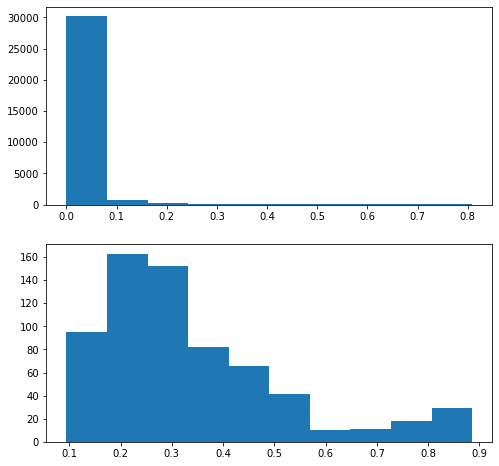

In [20]:
plt.figure(figsize = (8,8))
plt.subplot(211)
plt.hist(predictions_test[:,1][y_test['FailureWindow']==0])
plt.subplot(212)
plt.hist(predictions_test[:,1][y_test['FailureWindow']==1])

<Figure size 576x576 with 0 Axes>

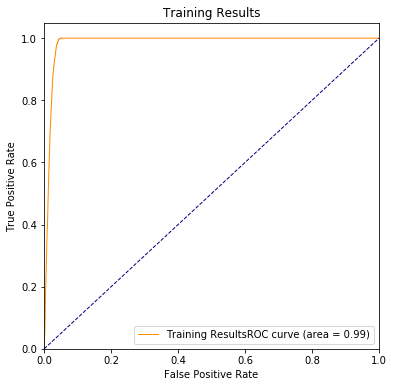

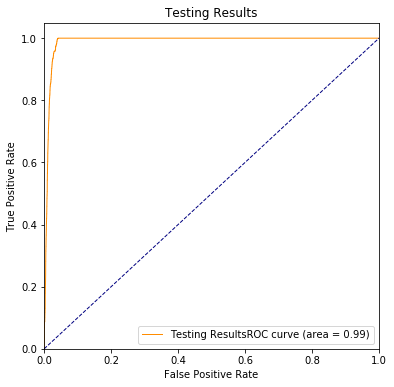

0.9895225735853103

In [21]:
plt.figure(figsize = (8,8))
plot_roc(predictions_train[:,1], y_train, label = 'Training Results')
plot_roc(predictions_test[:,1], y_test, label = 'Testing Results')

As you can imagine, using one feature, the results are not very good.

**But you have created a Sklearn Pipeline! Wohoo!**

<a id='3e'></a>
### E. Upsert Model 

The next step is even more exciting. We want to `upsert` the pipeline onto the C3 AI Suite. Keep in mind that since Sklearn Pipeline is not directly supported by C3 AI Suite, we need to do some hacks in order for it to work properly.

1. The first step is to **serialize** and **compress** a `python` object. The Sklearn Pipeline that we have just created is the `python` object to serialize and compress. We will save the serialized and compressed object.

> Note: That you can check out the slides if you forget about C3 pipeline types. This is **highly recommended**, as we will work on them later in the assignment as well.

In [22]:
import dill

In [23]:
sklearnPipe = c3.PythonSerialization.serialize(obj=pipeline)

This is how the compressed and serialized `python` object looks:

In [24]:
sklearnPipe

'eJxtlWl/1EQcx7cFBVagosglKh5IBVkotIgKdqEKysIKg0JUICTZaRPIJvtLZluqFgvSpQVEAeVULg/EC1BAVBSd8fZd+NQnvgOdmd1tQcmDfJI5vv/zN9Nd68QbfWpFQargFajvBTS5vPqBxANbUNOF2nrjhkQiETNaiDFoLQYP/DfghgFARAtR6NA49oK2VM5iVnIls4KcFeVWOpZPoyRulMAhXRhabwyTgA6PuWaeWgGG9RpDqwMxyyHZawyW/05Y6MRNvUad/A7M2MoXfBqbMaWBieFOzvP9lKneSbONMtNiTJoYcc24ly+EETPzYa7oy4BGGhMVqpgvdKacMKIpM1/0mWdFkdVpFvMWc1HXg5sJRhk3qgil21aEW0q4lWC0o/clc6yzIFG3GbVyhTcXYzKJTM12jCUYV58ZZNTI0XkYn81ml/wjH/3KJBgm2O4Id6QxRE6bTpijTozbezCR4A5tigZqEHeWcBfBJJ2eRn5KwRIJ3K2X+BbzggbcU8K9BPeVMJngfl0IlUITUyR/lDFc8SPqhEHMoqLDUF/CAwRTK86rashYk5iWSfTgQXeS9tfGdFdiUwQztmMmQUN9piZT24NZbjnK1rmYXY6ykaBJRun+P745dp+k3SZXW6v4Fn55Lj/Bz6fnL5y0WlxsaknjIWVhLsHDDI/YurrtVmTiUXeqq32Z50rb8wkeq9hudpsUcLxcyD+aLL4VJ/ge0WctEKfFl/xDsW1a16NppBV0AcFChha7v2TUxONV7BMKu4hgcQX7ZBk7QS4Vp/m5FeI7flgc4afSkdjBD28We8Wl0Wk8pbhLCDIMS23jZpXTSpeb7TSKvTDAMm1uZmpWQ2o2skW7hKf7VTELy/tVISsdyiaMPSZ3pQqOlVzesiCJFVIJpAsr63XFAlMvCmjAYjyTdWXPK3qH6zEa4Nk+I6nI7TkzDn3pAFbpBFpFFmK1MUh+stCHsThReYyRqjUZjSxGc2Yh7JBbnnN

Since we are feeding our Sklearn Pipeline to a C3 Sklearn Pipeline type, we need to have all the required fields of a C3 Sklearn Pipeline type. We can do `C3ShowType` on any C3 environment in order to check the required fields. Here is a screenshot. What fields do you notice as required fields?

![title](http://learnc3.ai/wp-content/uploads/2020/01/SkLearnPipe.png)

In [25]:
technique = c3.SklearnTechnique(
                        # This tells ML pipeline what to import.
                        name="pipeline.Pipeline",
                        # This tells ML pipeline what method to call when we invoke the C3 action process() later.
                        processingFunctionName="transform")

Let's take a look at what C3 SklearnTechnique type is:

In [26]:
technique.toJson()

{'type': 'SklearnTechnique',
 'name': 'pipeline.Pipeline',
 'processingFunctionName': 'transform',
 'keepInputColumnIndices': False}

Now we want to create a JSON object to specify the Sklearn Pipeline. This will conform our Sklearn Pipeline to the C3 SklearnPipeline type.

In [27]:
sklearnPipe_dic = {'trainedModel': {'model' : sklearnPipe, 
                                    'description': 'trained from skLearn pipeline that does standardScaler and Logistic Regression'},
                   'name': 'sklearnPipe',
                   'technique': technique.toJson()}

**Upsert!**

In [28]:
upsertedPipeline = c3.SklearnPipe.upsert(this = sklearnPipe_dic)

We can get this SklearnPipeline in order to see if it has been succesfully upserted. Note that the difference between `get` and `fetch` is that `get` can get one object while `fetch` can fetch multiple objects.

If you've made it this far, looks like everything went well! But note, since we have multiple steps in the Sklearn Pipeline but the c3 SklearnPipe type only supports one technique at a time, the model we have upserted **will not be retrainable**. If you need to retrain your models, we recommend building your own C3 model, which will be covered next!

In [29]:
retrievedPipeline = c3.SklearnPipe.get(this = upsertedPipeline)
print("Retrieved upserted MLSerialPipeline with id '%s'!" % retrievedPipeline.id)

Retrieved upserted MLSerialPipeline with id '5fed4633-06b8-4d7a-826f-d5d08440dd5e'!


<a id='4'></a>
## Section 4 - Method 2: Train on the Platform

<a id='4a'></a>
### A. Data Preparation 

The reason why we want to train on the platform is because (1) the models **will be retrainable** and you can set up cron jobs to train models regularly, and 2. all types will be maintained and supported by C3.

Remember, up to this point, we have defined:
1. `res_train` that contains all the **training set** information (features + labels)
2. `res_test` that contains all the **test set** information (features + labels)

Also, remember that **c3Dataset types** are required as model inputs. Let's create the following **c3Datasets** preparing for model training:
1. `x_train` for **training features**
2. `y_train` for **training labels**
3. `x_test` for **test features**
4. `y_test` for **test labels**

> Hint 1: You can always `c3ShowType(Dataset)` on the environment to read documentation on how to use certain types.

> Hint 2: Remember to apply the mask to reject periods after failure has occured.

> Hint 3: Due to a bug in this server version, you will need to wrap any outputs of Dataset functions returning `mixing Dataset` with `c3.Dataset`, i.e., `c3.Dataset(mixingDatasetReturnObject)`.

In [10]:
test = c3.Dataset.toPandas(dataset = c3.Dataset.extractColumns(
    this=c3.Dataset.rejectRows(
        this=ds_train, 
        conditionColumn=mask), 
    columns=features + [label]))

In [11]:
test.shape

(108340, 3)

In [12]:
### START CODE HERE ### (≈ 9 lines of code)
train_ds = c3.Dataset.fromEvalMetricsResult(result = res_train).rejectRows(mask)
test_ds  = c3.Dataset.fromEvalMetricsResult(result = res_test).rejectRows(mask)

x_train = train_ds.extractColumns(features)
y_train = train_ds.extractColumns([label])
x_test = test_ds.extractColumns(features)
y_test = test_ds.extractColumns([label])
x_whole = c3.Dataset.concatenateDatasets([x_train,x_test])

# items= [('type', 'Dateset')]
# items.extend(x_whole.toJson().items())
# x_whole = c3.Dataset(**collections.OrderedDict(items))

tmp = x_whole.toJson()
print(x_whole.toJson())
tmp['type'] = 'Dataset'
x_whole = c3.Dataset(**tmp)

### END CODE HERE ###
print("x_train shape is " + str(x_train.shape))
print("y_train shape is " + str(y_train.shape))
print("x_test shape is " + str(x_test.shape))
print("y_test shape is " + str(y_test.shape))
print("x_whole shape is " + str(x_whole.shape))

In [10]:
x_whole.shape

c3.Arry<int>([140634, 2])

**Expected Output**:
* `x_train` has shape of `(108340, 2)`
* `y_train` has shape of `(108340, 1)`
* ` x_test` has shape of `(32294, 2)`
* `y_test` has shape of `(32294, 1)`

<a id='4b'></a>
### B. Define C3 Machine Learning Pipelines

Now that you have created all the c3Datasets for training and tests, it is a good time to define **C3 pipelines**. Remember that some of the benefits of defining C3 pipelines include:
1. You can leverage the power of the platform to train models;
2. Easy to retrain and easy to set up Cron jobs to train models regularly;
3. Easy to tigger DFE (Data Flow Events) to train models.

Let's first define the same pipelines as the ones in the lecture. We will define a pipeline that contains
1. a preprocessing pipeline that contains a sklearn pipe that does standard scaling and a sklearn pipe that does PCA
2. a sklearn pipe that does logistic regression

Why don't you try to define these two C3 pipelines. Remember you can always refer to the slides if you are stuck.

First, let's define a pre-processing pipeline that contains a `SklearPipe` that does **standard scaling** and another `SklearPipe` that does **PCA**,

Remember, the reason why we need the `MLStep` is to associate **metadata** with **each** `MLPipe` inside the `MLSerialPipeline`.

> Hint: Remember to set PCA's parameter to fit your data if you decide to set parameters on PCA.

In [54]:
### START CODE HERE ### (≈ 4 lines of code)
standardScaler = c3.SklearnPipe(
    name = "standardScaler",
    technique = c3.SklearnTechnique(
        name = "preprocessing.StandardScaler",
        processingFunctionName = "transform"
    )
)
### END CODE HERE ###
standardScaler

c3.SklearnPipe(
 name='standardScaler',
 noTrainScore=False,
 untrainableOverride=False,
 technique=c3.SklearnTechnique(
             name='preprocessing.StandardScaler',
             processingFunctionName='transform',
             keepInputColumnIndices=False))

In [55]:
### START CODE HERE ### (≈ 4 lines of code)
pca = c3.SklearnPipe(
    name = "pca",
    technique = c3.SklearnTechnique(
        name = "decomposition.PCA",
        processingFunctionName = "transform",
        hyperParameters = {"n_components" : 2}
    ) 
)
### END CODE HERE ###
pca

c3.SklearnPipe(
 name='pca',
 noTrainScore=False,
 untrainableOverride=False,
 technique=c3.SklearnTechnique(
             name='decomposition.PCA',
             hyperParameters=c3.Mapp<string, any>({'n_components': 2}),
             processingFunctionName='transform',
             keepInputColumnIndices=False))

In [56]:
### START CODE HERE ### (≈ 4 lines of code)
preprocessPipeline = c3.MLSerialPipeline(
                        name = "preprocessPipeline",
                        steps = [
                            c3.MLStep(
                                name = "standardScaler",
                                pipe = standardScaler
                            ),
                            c3.MLStep(
                                name = "pca",
                                pipe = pca
                            ),
                        ]
                     )
### END CODE HERE ###
preprocessPipeline

c3.MLSerialPipeline(
 name='preprocessPipeline',
 noTrainScore=False,
 untrainableOverride=False,
 steps=c3.Arry<MLStep>([c3.MLStep(
          name='standardScaler',
          pipe=c3.SklearnPipe(
                 name='standardScaler',
                 noTrainScore=False,
                 untrainableOverride=False,
                 technique=c3.SklearnTechnique(
                             name='preprocessing.StandardScaler',
                             processingFunctionName='transform',
                             keepInputColumnIndices=False))),
         c3.MLStep(
          name='pca',
          pipe=c3.SklearnPipe(
                 name='pca',
                 noTrainScore=False,
                 untrainableOverride=False,
                 technique=c3.SklearnTechnique(
                             name='decomposition.PCA',
                             hyperParameters=c3.Mapp<string, any>({'n_components': 2}),
                             processingFunctionName='transform',
  

**Expected Output**:

`MLSerialPipeline({'steps': [MLDatasetDatasetStep({'pipe': SklearnPipe({'technique': SklearnTechnique({'type': u'SklearnTechnique', 'name': 'preprocessing.StandardScaler', 'processingFunctionName': 'transform'}), 'type': u'SklearnPipe', 'name': 'standardScaler'}), 'type': u'MLDatasetDatasetStep', 'name': 'standardScaler'}), MLDatasetDatasetStep({'pipe': SklearnPipe({'technique': SklearnTechnique({'hyperParameters': {'n_components': 2}, 'type': u'SklearnTechnique', 'name': 'decomposition.PCA', 'processingFunctionName': 'transform'}), 'type': u'SklearnPipe', 'name': 'pca'}), 'type': u'MLDatasetDatasetStep', 'name': 'pca'})], 'type': u'MLSerialPipeline', 'name': 'preprocessPipeline'})`

Now, define a `SklearPipe` that performs **logistic regression**:

In [57]:
### START CODE HERE ### (≈ 7 lines of code)
logisticRegression = c3.SklearnPipe(
    name = "LoghisticRegression",
    technique = c3.SklearnTechnique(
        name = "linear_model.LogisticRegression",
        processingFunctionName = "predict",
        hyperParameters = {'random_state': 42}
    ) 
)
### END CODE HERE ###
logisticRegression

c3.SklearnPipe(
 name='LoghisticRegression',
 noTrainScore=False,
 untrainableOverride=False,
 technique=c3.SklearnTechnique(
             name='linear_model.LogisticRegression',
             hyperParameters=c3.Mapp<string, any>({'random_state': 42}),
             processingFunctionName='predict',
             keepInputColumnIndices=False))

**Expected Output:**

`SklearnPipe({'technique': SklearnTechnique({'hyperParameters': {'random_state': 42}, 'type': u'SklearnTechnique', 'name': 'linear_model.LogisticRegression', 'processingFunctionName': 'predict'}), 'type': u'SklearnPipe', 'name': 'LogisticRegression'})`

After you have created the two components, we can define a pipeline to include these two C3 types, defined above, and this pipeline will be the final pipeline for the model to run. Use `MLAccuracyMetric` and `MLRecallMetric` as the two scoring metrics.

> Note: Remember that a pipeline **can** contain multiple pipelines and/or leaf pipes.

In [58]:
### START CODE HERE ### (≈ 8 lines of code)
lrPipeline = c3.MLSerialPipeline(
    name = "lrPipeline",
    steps = [
        c3.MLStep(
            name = "preprocess",
            pipe = preprocessPipeline
        ),
        c3.MLStep(
            name = "classifier",
            pipe = logisticRegression
        )
    ],
    scoringMetrics = c3.MLScoringMetric.toScoringMetricMap([c3.MLRecallMetric(), c3.MLAccuracyMetric()])
)
### END CODE HERE ###
lrPipeline

c3.MLSerialPipeline(
 name='lrPipeline',
 noTrainScore=False,
 scoringMetrics=c3.Mapp<string, MLScoringMetric>({'MLAccuracyMetric': c3.MLAccuracyMetric(),
                  'MLRecallMetric, threshold=0.0': c3.MLRecallMetric(
                                                    threshold=0.0)}),
 untrainableOverride=False,
 steps=c3.Arry<MLStep>([c3.MLStep(
          name='preprocess',
          pipe=c3.MLSerialPipeline(
                 name='preprocessPipeline',
                 noTrainScore=False,
                 untrainableOverride=False,
                 steps=c3.Arry<MLStep>([c3.MLStep(
                          name='standardScaler',
                          pipe=c3.SklearnPipe(
                                 name='standardScaler',
                                 noTrainScore=False,
                                 untrainableOverride=False,
                                 technique=c3.SklearnTechnique(
                                             name='preprocessing.Standar

**Expected Output**:

`
MLSerialPipeline({'scoringMetrics': Obj({u'[object Obj:MLRecallMetric]': {u'type': u'MLRecallMetric'}, u'[object Obj:MLAccuracyMetric]': {u'type': u'MLAccuracyMetric'}}), 'type': u'MLSerialPipeline', 'name': 'lrPipeline', 'steps': [MLDatasetDatasetStep({'pipe': SklearnPipe({'technique': SklearnTechnique({'type': u'SklearnTechnique', 'name': 'preprocessing.StandardScaler', 'processingFunctionName': 'transform'}), 'type': u'SklearnPipe', 'name': 'standardScaler'}), 'type': u'MLDatasetDatasetStep', 'name': 'preprocess'}), MLDatasetDatasetStep({'pipe': SklearnPipe({'technique': SklearnTechnique({'hyperParameters': {'random_state': 0}, 'type': u'SklearnTechnique', 'name': 'linear_model.LogisticRegression', 'processingFunctionName': 'predict'}), 'type': u'SklearnPipe', 'name': 'LogisticRegression'}), 'type': u'MLDatasetDatasetStep', 'name': 'classifier'})]})
`

We have now defined the correct pipeline structure for the model to train. Now, we should train our model!
Note that all the paramater names are required in order to avoid confusion.

In [105]:
### START CODE HERE ### (≈ 1 lines of code)
#trainedLr = c3.MLSerialPipeline.train(this=lrPipeline, input=x_train, targetOutput=y_train)
### END CODE HERE ###
#print("MLSerialPipeline '%s' trained with training accuracy %f and recall %f." % (trainedLr.toJson()["name"], trainedLr.toJson()["trainingScores"]['MLAccuracyMetric'], trainedLr.toJson()["trainingScores"]['MLRecallMetric, threshold=0.0']))

<a id='4c'></a>
### C. Evaluate Training Results

Our model is now trained. Let us evaluate the results. Remember, there are two functions that we can do:
1. `process` will give you the **predictions** from the model;
2. `score` will give you the **score of the scoring metric** that you have defined.

#### Processing Predictions from a trained pipeline

In [19]:
predictions = c3.MLSerialPipeline.process(this=trainedLr, input=x_train)
c3.Dataset.toPandas(dataset=predictions).head(3)

prediction
SMBLB3_2011-01-01T00:00:00         0.0
SMBLB3_2011-01-02T00:00:00         0.0
SMBLB3_2011-01-03T00:00:00         0.0

#### Scoring a trained pipeline on train and test sets

In [20]:
### START CODE HERE ### (≈ 1 lines of code)
train_score = c3.MLSerialPipeline.score(this=trainedLr, input=x_train,targetOutput=y_train)
### END CODE HERE ### 
train_score

c3.Mapp<string, double>({'MLAccuracyMetric': 0.9791212848440096,
 'MLRecallMetric, threshold=0.0': 0.1845051500223914})

In [21]:
### START CODE HERE ### (≈ 1 lines of code)
test_score = c3.MLSerialPipeline.score(this=trainedLr, input=x_test, targetOutput=y_test)
### END CODE HERE ### 
test_score

c3.Mapp<string, double>({'MLAccuracyMetric': 0.9792840775376231,
 'MLRecallMetric, threshold=0.0': 0.136431784107946})

**Expected Output**: `train_score`

`Obj({'MLAccuracyMetric': 0.973232416466679, 'MLRecallMetric, threshold=0.0': 0.38783943329397874})`

**Expected Output**: `test_score`

`Obj({'MLAccuracyMetric': 0.9762494581036725, 'MLRecallMetric, threshold=0.0': 0.39822134387351776})`

<a id='4d'></a>
### D. Predict Probabilities 

Great! You have a model. However, the model **only outputs 0 and 1 as results**. Can you adjust the logistic regression pipe in order for the model to output probabilities?

Note that, since the model will now output probabilities instead of classes, the accuracy and recall scoring metrics no longer apply to the pipeline, so you will need to remove the scoring metrics.

**Step 1**: Revise the pipeline to output probabilities instead of binary outputs:

In [22]:
### START CODE HERE ### (≈ 8 lines of code)
logisticRegression = c3.SklearnPipe(
    name = "LoghisticRegression",
    technique = c3.SklearnTechnique(
        name = "linear_model.LogisticRegression",
        processingFunctionName = "predict_proba",
        hyperParameters = {'random_state': 42}
    ) 
)
### END CODE HERE ###
lrPipeline = c3.MLSerialPipeline(
                name="lrPipeline",
                steps=[c3.MLStep(name="preprocess",
                                               pipe=preprocessPipeline),
                       c3.MLStep(name="classifier",
                                               pipe=logisticRegression)],
             )

**Step 2**: Train the model:

In [23]:
### START CODE HERE ### (≈ 1 lines of code)
trainedLr = c3.MLSerialPipeline.train(this=lrPipeline, input=x_train, targetOutput=y_train)
### END CODE HERE ###

**Step 3**: Get probabilities from model:

Now, although have a trained model, you **cannot** call score on the `MLSerialPipeline` because the accuracy metrics do not work. What should you do in order to get probabilities? 

You can do a `c3ShowType` on the type or review the slides if you forget.

In [24]:
### START CODE HERE ### (≈ 4 lines of code)
risk_scores_train = c3.MLSerialPipeline.process(this=trainedLr, input=x_train)
risk_scores_test = c3.MLSerialPipeline.process(this=trainedLr, input=x_test)
### END CODE HERE ###

In [41]:
print("Training risk score partial")
risk_score_train_df = c3.Dataset.toPandas(dataset = risk_scores_train)

Training risk score partial


In [42]:
risk_score_train_df['source'] = risk_score_train_df.index.str.split('_').str[0]
risk_score_train_df['timestamp'] = pd.to_datetime(risk_score_train_df.index.str.split('_').str[1],format="%Y-%m-%dT%H:%M:%S.%f")

In [46]:
risk_score_train_df[risk_score_train_df['source'] == 'SMBLB55'].tail(1)

0.0       1.0   source  timestamp
SMBLB55_2014-09-27T00:00:00  0.759179  0.240821  SMBLB55 2014-09-27

In [51]:
print("Test risk score partial")
risk_score_test_df = c3.Dataset.toPandas(dataset = risk_scores_test)

Test risk score partial


In [54]:
#risk_score_test_df

In [53]:
risk_score_test_df['source'] = risk_score_test_df.index.str.split('_').str[0]
risk_score_test_df['timestamp'] = pd.to_datetime(risk_score_test_df.index.str.split('_').str[1],format="%Y-%m-%dT%H:%M:%S.%f")

In [56]:
risk_score_test_df[risk_score_test_df['source'] == 'SMBLB1'].tail(1)

0.0      1.0  source  timestamp
SMBLB1_2015-02-05T00:00:00  0.18864  0.81136  SMBLB1 2015-02-05

**Expected Output**: Training risk-score partial:

![title](http://learnc3.ai/wp-content/uploads/2020/02/riskScoreTrain2.png)

**Expected Output**: Test risk-score partial:

![title](http://learnc3.ai/wp-content/uploads/2020/02/riskScoreTest2.png)

Now, plot the **ROC** and see the performance.

/opt/conda/envs/py-pythonEnv/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


<Figure size 576x576 with 0 Axes>

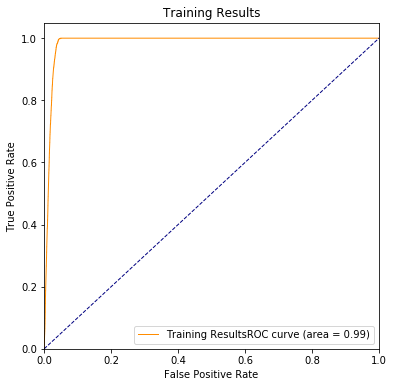

/opt/conda/envs/py-pythonEnv/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


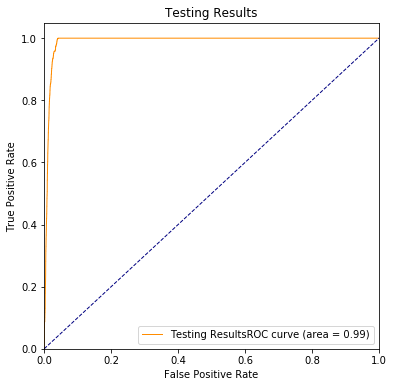

0.9895230476265962

In [61]:
y_train = df_train[df_train['HasEverFailed']==0][['FailureWindow']]
y_test = df_test[df_test['HasEverFailed']==0][['FailureWindow']]
plt.figure(figsize = (8,8))

plot_roc(risk_score_train_df.as_matrix()[:,1], y_train, label = 'Training Results')
plot_roc(risk_score_test_df.as_matrix()[:,1], y_test, label = 'Testing Results')

<a id='4e'></a>
### E. Upsert Model

Wonderful!! What do you think about the model? There probably is room for improvements, but let's leave it for later. Now, since we have a good/decent model, we want to `upsert` it. Upserting a model defined by the C3 types is much easier than upserting a sklearn model, similar to waht you have done previously. Let's see how:

In [47]:
### START CODE HERE ### (≈ 1 lines of code)
upsertedPipeline = c3.MLSerialPipeline.upsert(this = trainedLr)
### END CODE HERE ### 
upsertedPipeline

c3.MLSerialPipeline(
 id='1a2e246c-1684-4e8e-8393-64733e0670ca',
 name='lrPipeline',
 meta=c3.Meta(
        created=datetime.datetime(2020, 7, 10, 9, 52, 49, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2020, 7, 10, 9, 52, 49, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2020, 7, 10, 9, 52, 49, tzinfo=datetime.timezone.utc)),
 version=1,
 typeIdent='PIPE:LN:SER',
 noTrainScore=False,
 untrainableOverride=False)

**Expected Output**: _Ignore the specific `timestamp` and `id` and focus on the **structure** of the expected output._

`Obj({'type': 'MLSerialPipeline', 'name': 'lrPipeline', 'meta': {'type': 'Meta', 'created': '2020-05-19T23:34:00Z', 'updated': '2020-05-19T23:34:00Z', 'timestamp': '2020-05-19T23:34:00Z'}, 'version': 1, 'id': '94c3246a-acd9-45d5-83fc-d69f05a3e5f2', 'typeIdent': 'PIPE:LN:SER'})`

Now this trained pipeline is upserted, it can be accessed in the following manner:

In [26]:
upserted = c3.MLSerialPipeline.get(this = upsertedPipeline)
print("MLSerialPipeline with id '%s' upserted!" % upserted.id)

MLSerialPipeline with id '3e413cba-1487-4d26-87d3-213dea7f6285' upserted!


Great! Now you have defined your first machine learning model on the platform!

In the next section, there will be much less help. But you should manage to get all the knowledge you need to define your own C3 machine learning models. Let us improve the results that you have got from the previous step!

#### Optional

Think about how to give a specific name and/or id to the model that you want to upsert. What should you change in the pipeline that you have trained?

<a id='4f'></a>
### F. Upsert Risk Score

Sometimes, you also want to `upsert` risk scores so that you can see how these risk scores evolve in the UI. Here, we will show you how to upsert risk scores, in four quick steps.

**Step 1**: Use process to get probabilities from the trained model:

In [ ]:
risk_scores = c3.MLSerialPipeline.process(this=trainedLr, input=x_whole)
risk_scores = c3.Dataset.toPandas(dataset=risk_scores)

In [ ]:
risk_scores.head(3)

**Step 2**: We can reformat the risk scores in order for us to better manipulate later when necessary to upsert risk score object.

In [ ]:
formatted_rs=risk_scores.rename(columns = {'1.0':'prediction'})
formatted_rs['smartBulb.id']=pd.Series({x: x.split('_')[0] for x in formatted_rs.index})
formatted_rs['smartBulb']=[{"id": sm_id} for sm_id in formatted_rs['smartBulb.id']]
formatted_rs['timestamp']=pd.to_datetime(pd.Series({x: x.split('_')[1] for x in formatted_rs.index}))
formatted_rs.reset_index(inplace=True)
formatted_rs = formatted_rs[["prediction", "smartBulb", "timestamp"]]

In [ ]:
formatted_rs.head()

**Step 3**: We want to create an object to upsert **as** risk scores to the platform:

In [ ]:
dict_list = formatted_rs.to_dict('records')
dict_list[:5]

**Step 4**: Before we upsert the risk scores, we want to remove all exisiting risk scores in the type. Then, we can upsert the risk scores using `mergeBatch()`:

In [ ]:
c3.SmartBulbPrediction.removeAll()

In [ ]:
# Check that all previous predictions have been removed
query = c3.SmartBulbPrediction.fetch()
query.count

In [ ]:
# Upserts all predictions to the platform
result = c3.SmartBulbPrediction.mergeBatch(objs=dict_list)
result.stats

<a id='5'></a>
## Section 5 - Improve Results on the Platform

There are several ways that you can improve the results of this machine learning model as it exists on the platform:
1. Change features;
2. Change what is in the pipeline;
3. Hyperparameter tuning.

You should be able to implement all these now!

<a id='5a'></a>
### A. Changing Features

We just used **one** feature in the model above. Can you try to look at all the compound metrics and select whatever features that you think could be helpful in improving the model performance?

In [29]:
features

['DurationOnInHours', 'SwitchCountPreviousWeek']

In [68]:
### START CODE HERE ### (≈ 3 lines of code)
features = ['AverageVoltage', 'AveragePower','AverageLumens', 'CumulativeSwitchCount', 
            'StandardDeviationWattsPreviousWeek', 'SwitchCountPreviousWeek']
featuresAndLabels = features + [mask, label]
### END CODE HERE ###

In [31]:
columns

['DurationOnInHours',
 'SwitchCountPreviousWeek',
 'HasEverFailed',
 'FailureWindow']

In [111]:
### START Train CODE HERE ### (≈ 11 lines of code)
start = datetime(2011,1,1)
end = datetime(2017,1,1)
interval = 'DAY'

spec = c3.EvalMetricsSpec(expressions = featuresAndLabels,
                          filter = "!(startsWith(id, 'SMBLB1') || startsWith(id, 'SMBLB2'))",
                          interval = interval,
                          start = start,
                          end = end)

res_train = c3.SmartBulb.evalMetricsWithMetadata(spec=spec, overrideMetrics=[failure_metric])
### END Train CODE HERE ###
### START Test CODE HERE ### (≈ 11 lines of code)
spec = c3.EvalMetricsSpec(expressions = featuresAndLabels,
                          filter = "startsWith(id, 'SMBLB1') || startsWith(id, 'SMBLB2')",
                          interval = interval,
                          start = start,
                          end = end)

res_test = c3.SmartBulb.evalMetricsWithMetadata(spec=spec, overrideMetrics=[failure_metric])
### END Test CODE HERE ###

In [35]:
c3.Dataset.toPandas(c3.Dataset.fromEvalMetricsResult(result=res_train)).head(3)

AverageLumens  AveragePower  AverageVoltage  \
SMBLB3_2011-01-01T00:00:00           100.0          1.50           11.95   
SMBLB30_2011-01-01T00:00:00          200.0          3.05           23.80   
SMBLB31_2011-01-01T00:00:00          100.0          1.45           11.95   

                             CumulativeSwitchCount  FailureWindow  \
SMBLB3_2011-01-01T00:00:00                     2.0            0.0   
SMBLB30_2011-01-01T00:00:00                    4.0            0.0   
SMBLB31_2011-01-01T00:00:00                    2.0            0.0   

                             HasEverFailed  \
SMBLB3_2011-01-01T00:00:00             0.0   
SMBLB30_2011-01-01T00:00:00            0.0   
SMBLB31_2011-01-01T00:00:00            0.0   

                             StandardDeviationWattsPreviousWeek  \
SMBLB3_2011-01-01T00:00:00                                  0.0   
SMBLB30_2011-01-01T00:00:00                                 0.0   
SMBLB31_2011-01-01T00:00:00                                 0.0   

                             SwitchCountPreviousWeek  
SMBLB3_2011-01-01T00:00:00                       0.0  
SMBLB30_2011-01-01T00:00:00                      0.0  
SMBLB31_2011-01-01T00:00:00                      0.0

In [112]:
ds_train = c3.Dataset.rejectRows(this=c3.Dataset.fromEvalMetricsResult(result=res_train),
                                 conditionColumn=mask)
ds_test = c3.Dataset.rejectRows(this=c3.Dataset.fromEvalMetricsResult(result=res_test),
                                 conditionColumn=mask)

In [129]:
ds_train.shape

c3.Arry<int>([108340, 7])

Instantiate the Train-Test-Split with the new features:

In [113]:
### START CODE HERE ### (≈ 4 lines of code)

x_train = ds_train.extractColumns(features)
y_train = ds_train.extractColumns([label])
x_test = ds_test.extractColumns(features)
y_test = ds_test.extractColumns([label])
x_whole = c3.Dataset.concatenateDatasets(datasets =[x_train,x_test])
# items= [('type', 'Dataset')]
# items.extend(x_whole.toJson().items())
# x_whole = c3.Dataset(**collections.OrderedDict(items))

tmp = x_whole.toJson()
tmp['type'] = 'Dataset'
x_whole = c3.Dataset(**tmp)
### END CODE HERE ###

In [125]:
#c3.Dataset.toPandas(y_train)

<a id='5b'></a>
### B. Change What is in the Pipeline - Build Scaler + Random Forest

Let us start with `MinMaxScaler` (with feature range of [0, 1]) and `RandomForest` pipeline. If your model is right, then you are free to build whatever model that you think will be the best fit of this problem.

Note that `MinMaxScaler` may not be the most suitable scaler. This is just for illustration of how you can set `hyperParameters` of a SklearnPipe when you define it.

In [38]:
### START CODE HERE ### (≈ 8 lines of code)
MinMaxScaler = c3.SklearnPipe(
    name = "MinMaxScaler",
    technique = c3.SklearnTechnique(
        name = "preprocessing.MinMaxScaler",
        processingFunctionName = "transform"
    )
)
### END CODE HERE ###
MinMaxScaler

c3.SklearnPipe(
 name='minMaxScaler',
 noTrainScore=False,
 untrainableOverride=False,
 technique=c3.SklearnTechnique(
             name='preprocessing.MinMaxScaler',
             processingFunctionName='transform',
             keepInputColumnIndices=False))

In [108]:
### START CODE HERE ### (≈ 8 lines of code)
randomForestClassifier = c3.SklearnPipe(
    name = "randomForestClassifier",
    technique = c3.SklearnTechnique(
        name = "ensemble.RandomForestClassifier",
        processingFunctionName = "predict_proba",
        hyperParameters = {'random_state': 42}
    ) 
)
### END CODE HERE ###
randomForestClassifier

c3.SklearnPipe(
 name='randomForestClassifier',
 noTrainScore=False,
 untrainableOverride=False,
 technique=c3.SklearnTechnique(
             name='ensemble.RandomForestClassifier',
             hyperParameters=c3.Mapp<string, any>({'random_state': 42}),
             processingFunctionName='predict_proba',
             keepInputColumnIndices=False))

Now let's combine the two pipes into an `MLSerialPipeline`.

In [117]:
### START CODE HERE ### (≈ 8 lines of code)
rfPipeline = c3.MLSerialPipeline(
                name="rfPipeline",
                steps=[
                    c3.MLStep(name="preprocess",
                              pipe=MinMaxScaler),
                    c3.MLStep(name="classifier",
                              pipe=randomForestClassifier)
                ],
    #scoringMetrics = c3.MLScoringMetric.toScoringMetricMap([c3.MLRecallMetric(), c3.MLAccuracyMetric()])
)
### END CODE HERE ###
rfPipeline

c3.MLSerialPipeline(
 name='rfPipeline',
 noTrainScore=False,
 untrainableOverride=False,
 steps=c3.Arry<MLStep>([c3.MLStep(
          name='preprocess',
          pipe=c3.SklearnPipe(
                 name='minMaxScaler',
                 noTrainScore=False,
                 untrainableOverride=False,
                 technique=c3.SklearnTechnique(
                             name='preprocessing.MinMaxScaler',
                             processingFunctionName='transform',
                             keepInputColumnIndices=False))),
         c3.MLStep(
          name='classifier',
          pipe=c3.SklearnPipe(
                 name='randomForestClassifier',
                 noTrainScore=False,
                 untrainableOverride=False,
                 technique=c3.SklearnTechnique(
                             name='ensemble.RandomForestClassifier',
                             hyperParameters=c3.Mapp<string, any>({'random_state': 42}),
                             processingFun

In [118]:
trainedrf = c3.MLSerialPipeline.train(this=rfPipeline, input=x_train, targetOutput=y_train)

In [116]:
# y_train.shape

c3.Arry<int>([108340, 1])

In [107]:
# test_score = c3.MLSerialPipeline.score(this=trainedrf, input=x_test, targetOutput=y_test)
# test_score

c3.Mapp<string, double>({'MLAccuracyMetric': 1.0,
 'MLRecallMetric, threshold=0.0': 0.0})

In [119]:
predictions = c3.MLSerialPipeline.process(this=trainedrf, input=x_train)
c3.Dataset.toPandas(dataset=predictions).head(3)

0.0  1.0
SMBLB3_2011-01-01T00:00:00  1.0  0.0
SMBLB3_2011-01-02T00:00:00  1.0  0.0
SMBLB3_2011-01-03T00:00:00  1.0  0.0

In [120]:
risk_scores_train = c3.MLSerialPipeline.process(this=trainedrf, input=x_train)
risk_scores_test = c3.MLSerialPipeline.process(this=trainedrf, input=x_test)

In [121]:
risk_score_train_df = c3.Dataset.toPandas(dataset = risk_scores_train)

In [122]:
risk_score_train_df.head()

0.0  1.0
SMBLB3_2011-01-01T00:00:00  1.0  0.0
SMBLB3_2011-01-02T00:00:00  1.0  0.0
SMBLB3_2011-01-03T00:00:00  1.0  0.0
SMBLB3_2011-01-04T00:00:00  1.0  0.0
SMBLB3_2011-01-05T00:00:00  1.0  0.0

In [123]:
risk_score_test_df = c3.Dataset.toPandas(dataset = risk_scores_test)
risk_score_test_df.head()

0.0  1.0
SMBLB1_2011-01-01T00:00:00  1.0  0.0
SMBLB1_2011-01-02T00:00:00  1.0  0.0
SMBLB1_2011-01-03T00:00:00  1.0  0.0
SMBLB1_2011-01-04T00:00:00  1.0  0.0
SMBLB1_2011-01-05T00:00:00  1.0  0.0

In [126]:
train_df = c3.Dataset.toPandas(dataset = ds_train)
test_df = c3.Dataset.toPandas(dataset = ds_test)

In [128]:
train_df.head()

AverageLumens  AveragePower  AverageVoltage  \
SMBLB3_2011-01-01T00:00:00     100.000000      1.500000       11.950000   
SMBLB3_2011-01-02T00:00:00     333.300000      5.125000       40.000000   
SMBLB3_2011-01-03T00:00:00     291.608333      4.250000       35.041667   
SMBLB3_2011-01-04T00:00:00     458.195833      7.041667       54.833333   
SMBLB3_2011-01-05T00:00:00     374.850000      5.583333       44.875000   

                            CumulativeSwitchCount  FailureWindow  \
SMBLB3_2011-01-01T00:00:00                    2.0            0.0   
SMBLB3_2011-01-02T00:00:00                   10.0            0.0   
SMBLB3_2011-01-03T00:00:00                   14.0            0.0   
SMBLB3_2011-01-04T00:00:00                   20.0            0.0   
SMBLB3_2011-01-05T00:00:00                   28.0            0.0   

                            StandardDeviationWattsPreviousWeek  \
SMBLB3_2011-01-01T00:00:00                            0.000000   
SMBLB3_2011-01-02T00:00:00                            0.000000   
SMBLB3_2011-01-03T00:00:00                            2.563262   
SMBLB3_2011-01-04T00:00:00                            1.891593   
SMBLB3_2011-01-05T00:00:00                            2.303002   

                            SwitchCountPreviousWeek  
SMBLB3_2011-01-01T00:00:00                      0.0  
SMBLB3_2011-01-02T00:00:00                      2.0  
SMBLB3_2011-01-03T00:00:00                     10.0  
SMBLB3_2011-01-04T00:00:00                     14.0  
SMBLB3_2011-01-05T00:00:00                     20.0

In [127]:
y_train = train_df[train_df['HasEverFailed']==0][['FailureWindow']]
y_test = test_df[test_df['HasEverFailed']==0][['FailureWindow']]
plt.figure(figsize = (8,8))

plot_roc(risk_score_train_df.as_matrix()[:,1], y_train, label = 'Training Results')
plot_roc(risk_score_test_df.as_matrix()[:,1], y_test, label = 'Testing Results')

KeyError: 'HasEverFailed'

<a id='5c'></a>
### C. Change What is in the Pipeline - Build Your Own Pipeline (Optional)

Can you create your own pipeline that you think would better suit this problem?

In [ ]:
# Not Graded
### START CODE HERE ###

### END CODE HERE ###

_You are almost done!_

<a id='5e'></a>
### D. Upsert Model

As we did before, **delete** the other models, and **upsert** your final model for future use. Try to give your model a `name` and `id`.


In [42]:
c3.MLSerialPipeline.removeAll()
### START CODE HERE ### (≈ 2 lines of code)
upsertedPipeline = c3.MLSerialPipeline.upsert(this=trainedrf)
### END CODE HERE ###
upsertedPipeline

c3.MLSerialPipeline(
 id='00867b6e-b5ce-41c0-bc85-8ff5f8b2d217',
 name='lrPipeline',
 meta=c3.Meta(
        created=datetime.datetime(2020, 7, 10, 9, 44, 59, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2020, 7, 10, 9, 44, 59, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2020, 7, 10, 9, 44, 59, tzinfo=datetime.timezone.utc)),
 version=1,
 typeIdent='PIPE:LN:SER',
 noTrainScore=False,
 untrainableOverride=False)

<a id='6'></a>
## Section 6 - Define a Custom Pipe implemented in Python (Optional)
You may write and execute custom `python` code inside a pipeline by creating a custom Type implementing the `MLPipe` interface, which would call your `python` code when the `MLPipe` actions are invoked (e.g. `train()`, `process()`).

The easiest way to do this is to follow the three step process below, where you extend the abstract Type `CustomPythonMLPipe`.
In your Javascript console, run `c3ShowType(CustomPythonMLPipe)` and `c3ShowType(CustomPythonMLTechnique)` for more details on how to use these Types.  The documentation will explain how to name the `python` methods so they will be called by the `MLPipe` actions.

**Step 1**: Copy the code snippet below into a file `ExampleCustomPythonMLPipe.c3typ` in your C3 package.

**Step 2**: Copy the code snippet below into a file `ExampleCustomPythonMLPipe.py` in your C3 package.

In [ ]:
class ShiftModel:
    """The "trained model" returned by ShiftDataset."""

    def __init__(self, offset):
        """Construct the "trained" model, where "offset" is a model parameter."""
        self.offset = offset

    def process(self, input):
        """Process input data using this trained model.

        Args:
            input (MiniDataFrame): data to be processed (MiniDataFrame defined in PythonMLHelper.py)
        """
        input.data = input.data + self.offset
        return input

    def params(self, paramKeys=None):
        """Get fitted model parameters.

        This method is typically called without the paramKeys argument after training the model, to retrieve all model
        parameters and store them in a field on the C3 object.  Subsequent calls to params() on the C3 object will
        retrieve model parameters from the C3 object directly, to avoid the need to deserialize/decompress this model.

        Args:
            paramKeys (list): parameter string names
        """
        if paramKeys is None:
            return {"offset": float(self.offset)}  # Remember to convert numpy data types to float!
        else:
            all_param_keys = ["offset"]  # names of all fitted model parameters
            # We do a float() conversion on all parameters below (without a check) because we only have
            # one parameter of numpy data type.  In general, you should check that the parameter needs a conversion
            # before converting.
            return {k: float(getattr(self, k)) for k in paramKeys if (k in all_param_keys) and hasattr(self, k)}

    def with_params(self, params):
        """Sets model parameters.

        Args:
            params (dict): key-value pairs are (parameter name string, parameter value)
        """
        for k, v in params.iteritems():
            setattr(self, k, v)
        return self


class ShiftDataset:
    """The "machine learning" algorithm (a toy example).

    Take all entries in the input Dataset and adds a fixed offset.  If you
    specify the the hyperparameter 'fixed_offset' in
    {@link #technique.hyperParameters}, training will have no effect.  If you
    do not specify any hyperparameters, the offset is calculated during
    training to be the negative of the minimum value in the Dataset.
    Therefore, if we process the original training Dataset, the minimum in the
    training Dataset is always shifted to 0.
    """

    def __init__(self, fixed_offset=None):
        """Instantiate the ML algorithm by setting the hyperparameter "fixed_offset"."""
        self.fixed_offset = fixed_offset

    def train(self, input, targetOutput=None):
        """Train the model and returns an instance of ShiftModel.

        Alternatively, you could define the process() function on this class,
        and return self.  Either approach is acceptable.

        Args:
            input (MiniDataFrame): training data (MiniDataFrame defined in PythonMLHelper.py)
            targetOutput: unused argument (included to conform with train() in common interface)
        """
        if self.fixed_offset is not None:
            return ShiftModel(offset=self.fixed_offset)
        else:
            # We do not use targetOutput in this example, although we could
            min_value = input.data.min()
            return ShiftModel(offset=-min_value)

**Step 3**: Deploy your C3 package to your tenant/tag.  Now, you should be able to build ML pipelines using `ExampleCustomPythonMLPipe` inside the steps, just as you have done above.

### Conclusion

Congratulations! You have developed, trained, and deployed and a machine learning model, both locally and on the platform!  

## Make sure to CLOSE AND HALT  (from bottom of the File menu) this notebook when you leave.

## Appendix - Kernel Installation Instructions <a class="anchor" id="apdx">
    
If the **`py-pythonEnv`** kernel is not available, perform the following:
1. Select the 'Kernel' tab at the top of this notebook, then select 'Manage Kernels';
2. Scroll to find `py-pythonEnv`, and click the 'Install' button;
> Note: This installation will "fail", but don't worry, exit the Manage Kernels UI and return to the main notebook.
3. Navigate to the 'File' tab located at the top of the notebook, and select 'Close and Hault'. This will close the notebook. Re-open it.
4. You should notice, in the upper-right corner, the kernel is now set correctly to `py-pythonEnv`. If it is not, navigate to the Kernel tab, then select 'Change Kernel' and select the appropriate option.